In [1]:
import carbonbench

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

# Process Targets

In [2]:
# 1 Process targets
# 1.1 Load targets
targets = ['GPP_NT_VUT_USTAR50', 'RECO_NT_VUT_USTAR50', 'NEE_VUT_USTAR50']
include_qc = True
test_QC_threshold = 1 # [0,1] with 1 being the highest quality data; the paper uses QC=1
y = carbonbench.load_targets(targets, include_qc)
y

,date,site,lat,lon,IGBP,Koppen,Koppen_short,GPP_NT_VUT_USTAR50,RECO_NT_VUT_USTAR50,NEE_VUT_USTAR50,NEE_VUT_USTAR50_QC
0,2009-01-01,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,8.989840,2.957700,-6.032130,0.0
1,2009-01-02,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,8.912250,2.977330,-5.934920,0.0
2,2009-01-03,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,9.356500,3.330460,-6.026040,0.0
3,2009-01-04,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,9.826600,3.794460,-6.032130,0.0
4,2009-01-05,FLX_AR-SLu,-33.464800,-66.459800,MF,B,BSh,9.727970,3.793040,-5.934920,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1435909,2023-12-27,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,1.013866,0.617556,-0.396310,0.0
1435910,2023-12-28,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,0.738017,0.734304,-0.003712,0.0
1435911,2023-12-29,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,0.744890,0.765398,0.020508,0.0
1435912,2023-12-30,JPX_JP-Tmd,42.735911,141.523147,DBF,D,Dfb,0.470808,0.907578,0.436770,0.0


In [3]:
# 1.2 Explore targets
print(f"Total number of sites: {y.site.nunique()}")
print(f"Total number of samples: {len(y)}, QC∈[0,1]")
if include_qc:
    print(f"Total number of top-quality samples: {len(y[y.NEE_VUT_USTAR50_QC==1])}, QC=1")

Total number of sites: 567
Total number of samples: 1304309, QC∈[0,1]
Total number of top-quality samples: 553467, QC=1


Train sites: 453, Test sites: 114

Koppen balance:
        overall  test
Koppen               
D           284    57
C           194    39
B            55    11
A            19     4
E            15     3


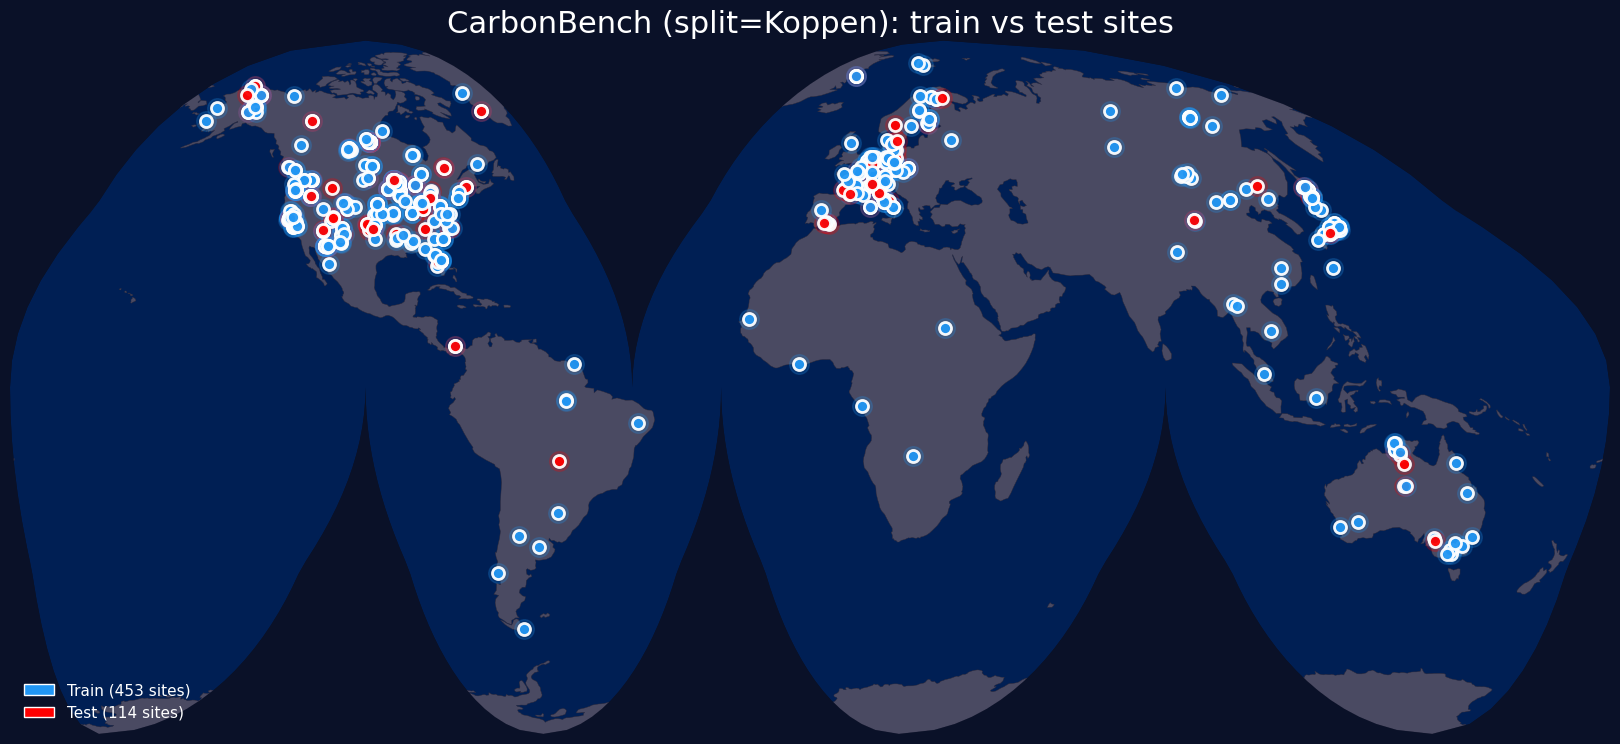

In [4]:
# 1.3 Split targets on train and test (site holdout)
split_type = 'Koppen' # 'IGBP'
y_train, y_test = carbonbench.split_targets(y, split_type, verbose=True, plot=True, save_path='./figs')

# Process Features

In [5]:
modis = carbonbench.load_modis()

era_feature_set = 'minimal' # minimal (6), standard (36), full (150)
era = carbonbench.load_era(era_feature_set)

train, val, test, x_scaler, y_scaler = carbonbench.join_features(y_train, y_test, modis, era, scale=True)

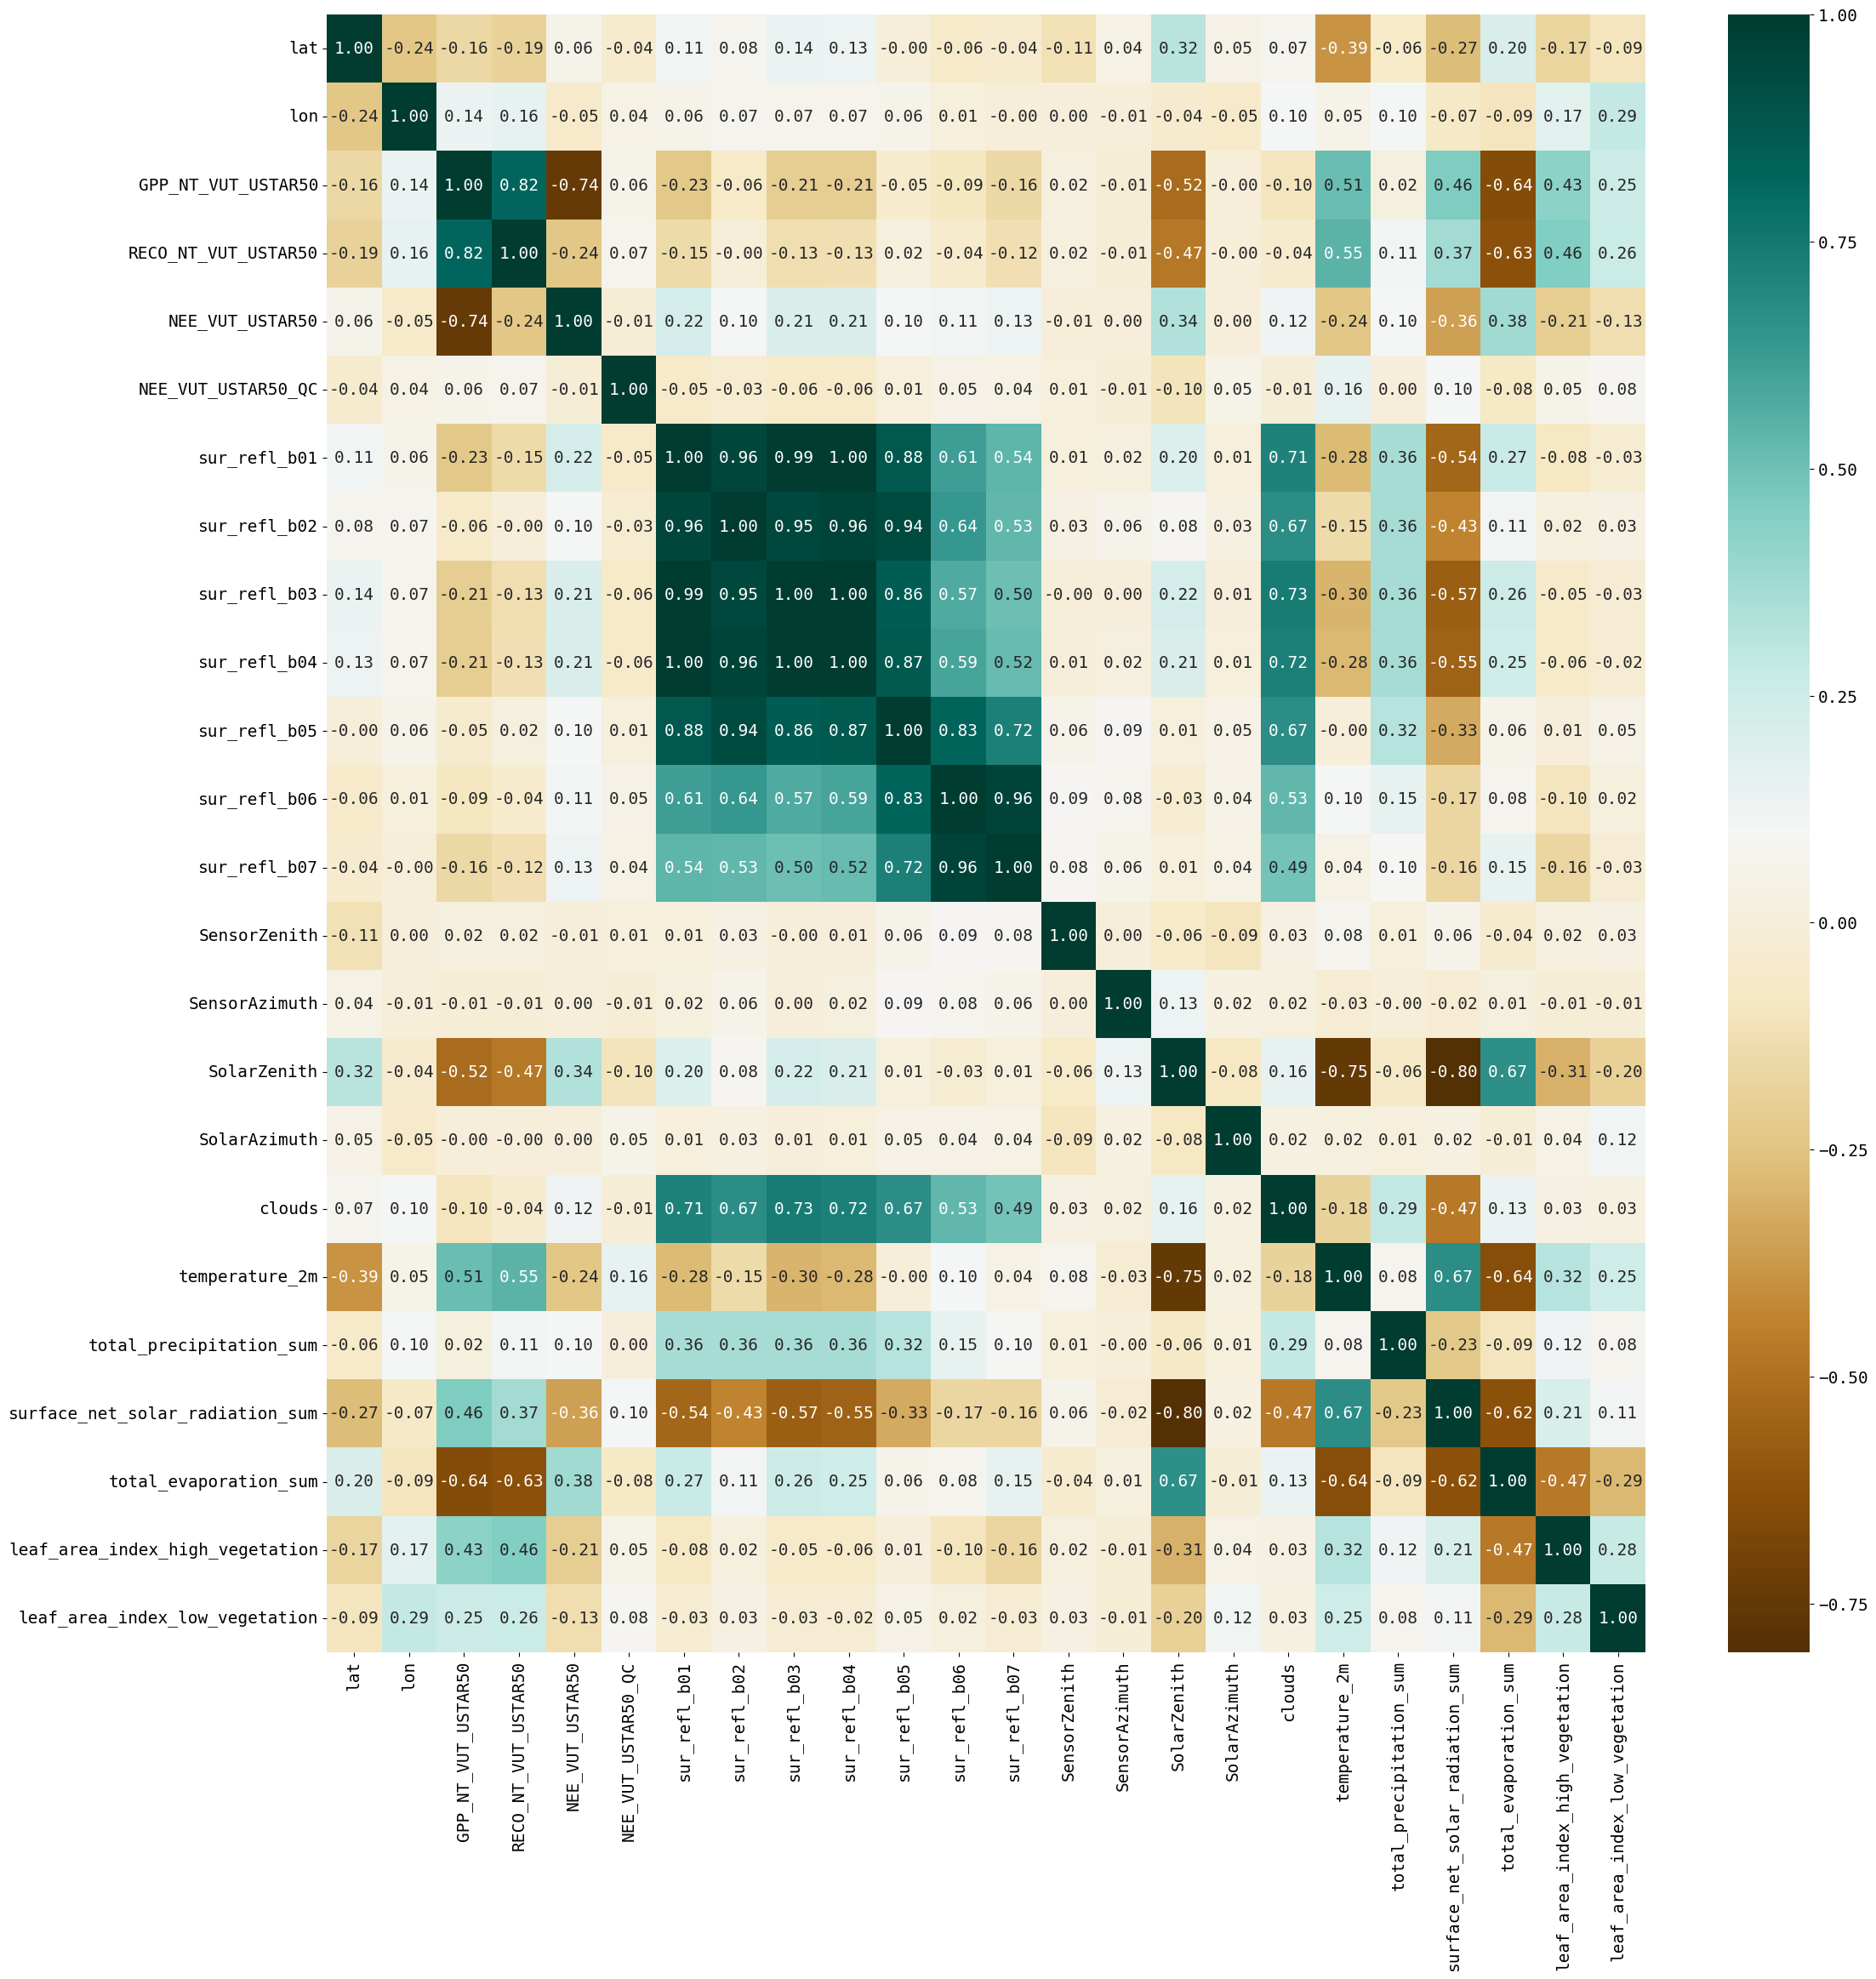

In [9]:
carbonbench.plot_feature_heatmap(train, save_path='./figs',  figsize=(25,25)) # full figsize=(150,150), minimal figsize=(25,25), standard figsize=(50,50)

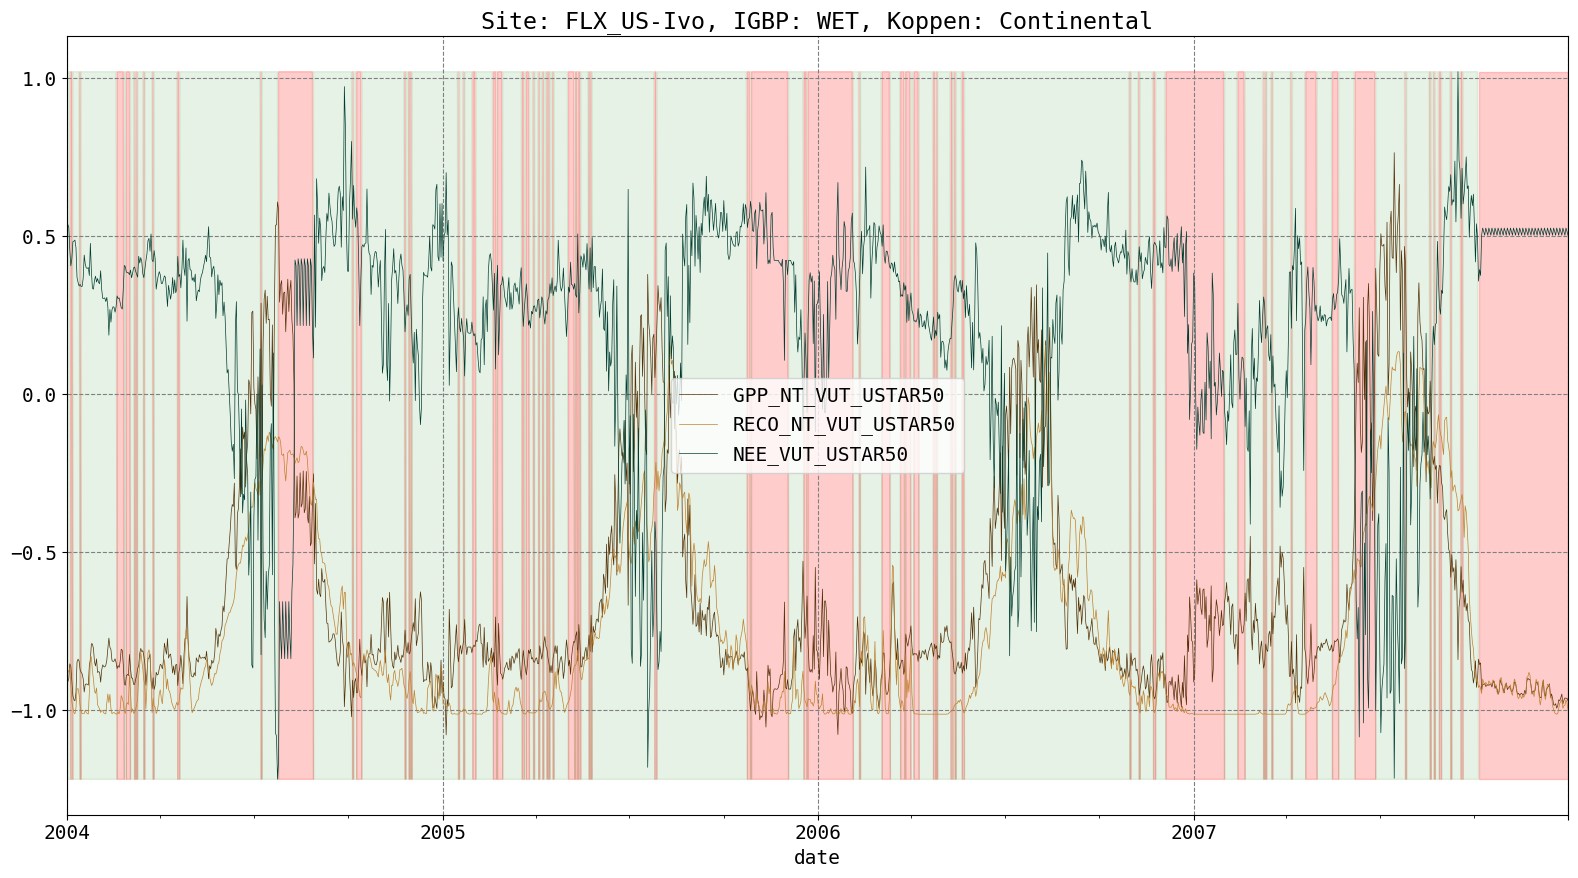

In [13]:
carbonbench.plot_site_ts(test, targets, include_qc, qc_threshold=0.75, site_name='FLX_US-Ivo', save_path='./figs')

In [6]:
'''Sliding Window (for time series modeling in torch)'''
batch_size = 32
window_size = 30
stride = 15 # make equal to window_size for full x_i, y_i parity 

train_hist = carbonbench.historical_cache(train, era, modis, x_scaler, window_size)
train_dataset = carbonbench.SlidingWindowDataset(train_hist, targets, include_qc, window_size=window_size, stride=stride, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Val set has last N% of observations from the train sites
val_hist = carbonbench.historical_cache(val, era, modis, x_scaler, window_size)
val_dataset = carbonbench.SlidingWindowDataset(val_hist, targets, include_qc, window_size=window_size, stride=stride, encoders=train_dataset.encoders,
                                               cat_features=['IGBP', 'Koppen', 'Koppen_short'])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [7]:
'''Tabular Processing (RF, XGBoost, etc.)'''
X_train_tab, y_train_tab, y_train_qc_tab = carbonbench.tabular(train, targets, include_qc, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
X_val_tab, y_val_tab, y_val_qc_tab = carbonbench.tabular(val, targets, include_qc, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
X_test_tab, y_test_tab, y_test_qc_tab = carbonbench.tabular(test, targets, include_qc, test_QC_threshold, cat_features=['IGBP', 'Koppen', 'Koppen_short'])

In [8]:
results = {}

## Tree Models

In [9]:
import xgboost as xgb

In [10]:
dtrain = xgb.DMatrix(X_train_tab.drop('site', axis=1), label=y_train_tab, weight=y_train_qc_tab.clip(1e-2, 1), enable_categorical=True)
dval = xgb.DMatrix(X_val_tab.drop('site', axis=1), label=y_val_tab, enable_categorical=True)

params = {
    'colsample_bynode': 1,
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_parallel_tree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'min_child_weight': 5
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'validation')],
    verbose_eval=50,
)

[0]	validation-rmse:0.98909
[50]	validation-rmse:0.60585
[100]	validation-rmse:0.58919
[150]	validation-rmse:0.58565
[200]	validation-rmse:0.58296
[250]	validation-rmse:0.58153
[300]	validation-rmse:0.58081
[328]	validation-rmse:0.58062


In [11]:
results['XGBoost'] = carbonbench.eval_tree_model(X_test_tab, y_test_tab, targets, model, y_scaler, method='xgb')

			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.419	2.345	0.673	0.541
RECO_NT_VUT_USTAR50:	0.216	1.780	0.801	0.411
NEE_VUT_USTAR50:	0.096	1.718	0.872	2.688


# PyTorch

In [12]:
'''Compute Upsampling Weights for the Custom Loss Function'''
IGBP = train['IGBP'].values
IGBP_weights = compute_class_weight(class_weight="balanced", classes=np.unique(IGBP), y=IGBP)
IGBP_weights = {str(k): float(IGBP_weights[i]) for i,k in enumerate(np.unique(IGBP))}

Koppen = train['Koppen'].values
Koppen_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Koppen), y=Koppen)
Koppen_weights = {str(k): float(Koppen_weights[i]) for i,k in enumerate(np.unique(Koppen))}

In [13]:
test_hist = carbonbench.historical_cache(test, era, modis, x_scaler, window_size)
test_dataset = carbonbench.SlidingWindowDataset(test_hist, targets, include_qc, window_size=window_size, QC_threshold=test_QC_threshold, stride=1, cat_features=['IGBP', 'Koppen', 'Koppen_short'],
                                    encoders=train_dataset.encoders)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [14]:
input_dynamic_channels = 20 # 12 - MODIS + lat + lon + ERA (6/36/150)
input_static_channels = sum(len(train_dataset.encoders[k].categories_[0]) for k in ("IGBP", "Koppen", "Koppen_short"))
hidden_dim = 128
latent_dim = 32 # TAM-RL specific
output_channels = len(targets)
dropout = 0.2
nhead = 4
layers = 1
tf_layers = 4
patch_len = 10
patch_stride = 5
num_epoch = 25
device = 'cuda'

## Train one model

In [15]:
model = carbonbench.ctlstm(input_dynamic_channels, input_static_channels, hidden_dim, output_channels, dropout, layers).to(device)
# model = carbonbench.patch_transformer(input_dynamic_channels, input_static_channels, output_channels,
#         window_size, stride, patch_len, patch_stride, hidden_dim, nhead, tf_layers, dropout).to(device)
#model = carbonbench.transformer(input_dynamic_channels, input_static_channels, output_channels, window_size, hidden_dim, nhead, tf_layers, dropout).to(device)
architecture = model.__class__.__name__

In [16]:
criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights) #torch.nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [17]:
best = np.inf
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, x_static, y, qc, igbp_w, koppen_w in train_loader:
        x, x_static, y, qc, igbp_w, koppen_w = x.to(device), x_static.to(device), y.to(device), qc.to(device), igbp_w.to(device), koppen_w.to(device)
        optimizer.zero_grad()
        if architecture in ['lstm', 'gru']:
            pred = model(x)
        else:
            pred = model(x, x_static)
            
        if criterion.__class__.__name__=='CustomLoss':
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
        else:
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])
            
        error.backward()
        optimizer.step()
    scheduler.step()
    
    if epoch % 5 == 0:
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y, _, _, _ in val_loader:
                x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                if architecture in ['lstm', 'gru']:
                    preds = model(x)
                else:
                    preds = model(x, x_static)
                val_preds.append(preds.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(val_loss, best)
#         if abs(best) < best_old:
#             torch.save(model.state_dict(), f'{model_folder}/model_state.pth')
        print(f'Validation RMSE: {val_loss:0.3f}')

  4%|█▊                                          | 1/25 [00:40<16:17, 40.71s/it]

Validation RMSE: 0.480


 24%|██████████▌                                 | 6/25 [03:34<11:18, 35.71s/it]

Validation RMSE: 0.389


 44%|██████████████████▉                        | 11/25 [06:28<08:16, 35.47s/it]

Validation RMSE: 0.371


 64%|███████████████████████████▌               | 16/25 [09:21<05:18, 35.44s/it]

Validation RMSE: 0.372


 84%|████████████████████████████████████       | 21/25 [12:15<02:21, 35.44s/it]

Validation RMSE: 0.373


100%|███████████████████████████████████████████| 25/25 [14:31<00:00, 34.85s/it]


In [18]:
results[architecture] = carbonbench.eval_nn_model(test_dataset, test, targets, model, architecture, device, y_scaler, window_size)

			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.588	1.553	0.662	0.422
RECO_NT_VUT_USTAR50:	0.438	1.170	0.862	0.352
NEE_VUT_USTAR50:	0.314	1.289	0.972	2.375


In [33]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

df = pd.concat([pd.DataFrame(results['ctlstm'][target]).assign(target=target)  for target in targets])
df = df.groupby(['target'])[['R2', 'RMSE', 'RAE', 'nMAE']].agg({
    'R2': ['median', q25, q75],
    'RMSE': ['median', q25, q75],
    'RAE': ['median', q25, q75],
    'nMAE': ['median', q25, q75]
}).round(3)
df

R2                 RMSE                  RAE         \
                    median    q25    q75 median    q25    q75 median    q25   
target                                                                        
GPP_NT_VUT_USTAR50   0.588  0.265  0.813  1.553  1.059  2.405  0.518  0.370   
NEE_VUT_USTAR50      0.314 -0.200  0.520  1.289  0.858  1.916  0.796  0.639   
RECO_NT_VUT_USTAR50  0.438 -0.131  0.730  1.170  0.816  1.780  0.658  0.461   

                             nMAE                
                       q75 median    q25    q75  
target                                           
GPP_NT_VUT_USTAR50   0.776  0.422  0.314  0.595  
NEE_VUT_USTAR50      1.130  2.375  1.348  4.856  
RECO_NT_VUT_USTAR50  1.056  0.352  0.275  0.492

# Train TAM-RL model

1. Pre-train the decoder (lstm);
2. Train TAM-RL (AE + TAMLSTM).

In [19]:
model = carbonbench.lstm(input_dynamic_channels, hidden_dim, output_channels, dropout, layers).to(device)
architecture = model.__class__.__name__

criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights) #torch.nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [20]:
'''Pre-training'''
best = np.inf
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, x_static, y, qc, igbp_w, koppen_w in train_loader:
        x, x_static, y, qc, igbp_w, koppen_w = x.to(device), x_static.to(device), y.to(device), qc.to(device), igbp_w.to(device), koppen_w.to(device)
        optimizer.zero_grad()
        if architecture in ['lstm', 'gru']:
            pred = model(x)
        else:
            pred = model(x, x_static)
            
        if criterion.__class__.__name__=='CustomLoss':
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
        else:
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])
            
        error.backward()
        optimizer.step()
    scheduler.step()
    
    if epoch % 5 == 0:
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y, _, _, _ in val_loader:
                x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                if architecture in ['lstm', 'gru']:
                    preds = model(x)
                else:
                    preds = model(x, x_static)
                val_preds.append(preds.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(val_loss, best)
        if best < best_old:
            best_model = model.state_dict()
        print(f'Validation RMSE: {val_loss:0.3f}')

  4%|█▊                                          | 1/25 [00:38<15:13, 38.08s/it]

Validation RMSE: 0.524


 24%|██████████▌                                 | 6/25 [03:30<11:12, 35.37s/it]

Validation RMSE: 0.475


 44%|██████████████████▉                        | 11/25 [06:23<08:13, 35.27s/it]

Validation RMSE: 0.444


 64%|███████████████████████████▌               | 16/25 [09:15<05:16, 35.11s/it]

Validation RMSE: 0.437


 84%|████████████████████████████████████       | 21/25 [12:07<02:20, 35.07s/it]

Validation RMSE: 0.427


100%|███████████████████████████████████████████| 25/25 [14:22<00:00, 34.51s/it]


In [21]:
model.load_state_dict(best_model)
results['lstm'] = carbonbench.eval_nn_model(test_dataset, test, targets, model, 'lstm', device, y_scaler, window_size)

			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.605	1.698	0.741	0.430
RECO_NT_VUT_USTAR50:	0.446	1.298	0.994	0.371
NEE_VUT_USTAR50:	0.267	1.367	1.024	2.703


In [34]:
inverse_model = carbonbench.ae_tamrl(input_channels=input_dynamic_channels+input_static_channels, 
                       code_dim=latent_dim, hidden_dim=latent_dim, output_channels=latent_dim).to(device)
#forward_model = carbonbench.tamlstm(input_dynamic_channels, latent_dim, hidden_dim, output_channels, dropout).to(device)
forward_model = carbonbench.ctlstm_decoder(input_dynamic_channels, latent_dim, hidden_dim, output_channels, dropout).to(device)
architecture = inverse_model.__class__.__name__

encoder_weights = {k.replace('encoder.', ''): v for k, v in best_model.items() if k.startswith('encoder.')}
forward_model.encoder.load_state_dict(encoder_weights)

criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights) #torch.nn.MSELoss() 
optimizer = optim.Adam(list(inverse_model.parameters())+list(forward_model.parameters()), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [35]:
train_dataset_tamrl = carbonbench.SlidingWindowDatasetTAMRL(train_hist, targets, include_qc, window_size=window_size, stride=stride, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
train_loader_tamrl = DataLoader(train_dataset_tamrl, batch_size=batch_size, shuffle=True)

val_dataset_tamrl = carbonbench.SlidingWindowDatasetTAMRL(val_hist, targets, include_qc, window_size=window_size, stride=stride, encoders=train_dataset.encoders,
                                               cat_features=['IGBP', 'Koppen', 'Koppen_short'])
val_loader_tamrl = DataLoader(val_dataset_tamrl, batch_size=batch_size, shuffle=True)

test_dataset_tamrl = carbonbench.SlidingWindowDatasetTAMRL(test_hist, targets, include_qc, window_size=window_size, QC_threshold=test_QC_threshold, stride=1, cat_features=['IGBP', 'Koppen', 'Koppen_short'],
                                    encoders=train_dataset.encoders) 
test_loader_tamrl = DataLoader(test_dataset_tamrl, batch_size=batch_size, shuffle=False, drop_last=False)

In [36]:
'''Training TAM-RL'''
best = np.inf
for epoch in tqdm(range(num_epoch)):
    inverse_model.train()
    forward_model.train()
    for x, x_static, y, qc, igbp_w, koppen_w, x_sup, x_static_sup in train_loader_tamrl:
        x, x_static, y, qc, igbp_w, koppen_w, x_sup, x_static_sup = x.to(device), x_static.to(device), y.to(device), qc.to(device),\
                                                                    igbp_w.to(device), koppen_w.to(device), x_sup.to(device), x_static_sup.to(device)
        optimizer.zero_grad()
        
        batch, window, _ = x.shape
        batch_dynamic_input = torch.cat((x, x_sup), dim=0)
        batch_static_input = torch.cat((x_static, x_static_sup), dim=0)

        batch_input = torch.cat((batch_dynamic_input, batch_static_input), dim=-1).to(device)
        latent_repr, _,_,_ = inverse_model(x=batch_input.float())
        
        batch_static_input = latent_repr[:x.shape[0]].unsqueeze(1).repeat(1, window, 1) # GET BATCH DATA FOR FORWARD MODEL
        pred = forward_model(x_dynamic=x.float().to(device), x_static=batch_static_input.float().to(device))
            
        if criterion.__class__.__name__=='CustomLoss':
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
        else:
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])
            
        error.backward()
        optimizer.step()
    scheduler.step()
    
    if epoch % 5 == 0:
        inverse_model.eval()
        forward_model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y, _, _, _, x_sup, x_static_sup in val_loader_tamrl:
                x, x_static, y, x_sup, x_static_sup = x.to(device), x_static.to(device), y.squeeze().to(device), x_sup.to(device), x_static_sup.to(device)

                batch, window, _ = x.shape
                batch_dynamic_input = torch.cat((x, x_sup), dim=0)
                batch_static_input = torch.cat((x_static, x_static_sup), dim=0)

                batch_input = torch.cat((batch_dynamic_input, batch_static_input), dim=-1).to(device)
                latent_repr, _,_,_ = inverse_model(x=batch_input.float())

                batch_static_input = latent_repr[:x.shape[0]].unsqueeze(1).repeat(1, window, 1) # GET BATCH DATA FOR FORWARD MODEL
                pred = forward_model(x_dynamic=x.float().to(device), x_static=batch_static_input.float().to(device))
                
                val_preds.append(pred.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        #val_loss = criterion(val_preds.to(device)[:,-1:,:], val_true[:, :3].to(device))
        val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(val_loss, best)
        if best < best_old:
            best_model_fw = forward_model.state_dict()
            best_model_inv = inverse_model.state_dict()
        print(f'Validation RMSE: {val_loss:0.3f}')

  4%|█▊                                          | 1/25 [01:03<25:22, 63.42s/it]

Validation RMSE: 0.502


 24%|██████████▌                                 | 6/25 [05:43<18:14, 57.63s/it]

Validation RMSE: 0.419


 44%|██████████████████▉                        | 11/25 [10:22<13:22, 57.31s/it]

Validation RMSE: 0.396


 64%|███████████████████████████▌               | 16/25 [15:03<08:36, 57.34s/it]

Validation RMSE: 0.392


 84%|████████████████████████████████████       | 21/25 [19:41<03:48, 57.05s/it]

Validation RMSE: 0.388


100%|███████████████████████████████████████████| 25/25 [23:18<00:00, 55.94s/it]


In [37]:
forward_model.load_state_dict(best_model_fw)
inverse_model.load_state_dict(best_model_inv)
results[architecture] = carbonbench.eval_tamrl_model(test_dataset_tamrl, test, targets, forward_model, inverse_model, architecture, device, y_scaler, window_size)

			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.657	1.488	0.641	0.420
RECO_NT_VUT_USTAR50:	0.473	1.159	0.839	0.362
NEE_VUT_USTAR50:	0.291	1.307	0.958	2.433


# Train Many Models

In [40]:
input_dynamic_channels = 20 # 12 - MODIS + lat + lon + ERA (6/36/150)
input_static_channels = sum(len(train_dataset.encoders[k].categories_[0]) for k in ("IGBP", "Koppen", "Koppen_short"))
hidden_dim = 128
latent_dim = 32 # TAM-RL specific
output_channels = len(targets)
dropout = 0.2
nhead = 4
layers = 1
tf_layers = 4
patch_len = 10
patch_stride = 5
num_epoch = 25
device = 'cuda'
base_args = {
    'input_dynamic_channels': input_dynamic_channels,
    'hidden_dim': hidden_dim,
    'output_channels': output_channels,
    'dropout': dropout,
}

In [41]:
for model_class in [carbonbench.lstm, carbonbench.ctlstm, carbonbench.gru,  carbonbench.ctgru, carbonbench.transformer, carbonbench.patch_transformer]: 
    architecture = model_class.__name__
    
    kwargs = base_args.copy()
    if architecture in ['lstm', 'gru']:
        kwargs['layers'] = layers
    else:
        kwargs['input_static_channels'] = input_static_channels
        
    if 'transformer' in architecture:
        kwargs['nhead'] = nhead
        kwargs['num_layers'] = tf_layers
        kwargs['seq_len'] = window_size
        if 'patch' in architecture:
            kwargs['pred_len'] = stride
            kwargs['patch_len'] = patch_len
            kwargs['stride'] = patch_stride
    else:
        kwargs['layers'] = layers
        
    model = model_class(**kwargs).to(device)
    criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights)#torch.nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3) 
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    
    best = np.inf
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for x, x_static, y, qc, igbp_w, koppen_w in train_loader:
            x, x_static, y, qc, igbp_w, koppen_w = x.to(device), x_static.to(device), y.to(device), qc.to(device), igbp_w.to(device), koppen_w.to(device)
            optimizer.zero_grad()
            if architecture in ['lstm', 'gru']:
                pred = model(x)
            else:
                pred = model(x, x_static)

            if criterion.__class__.__name__=='CustomLoss':
                error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
            else:
                error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])

            error.backward()
            optimizer.step()
        scheduler.step()

        if epoch % 5 == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                for x, x_static, y, _, _, _ in val_loader:
                    x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                    if architecture in ['lstm', 'gru']:
                        preds = model(x)
                    else:
                        preds = model(x, x_static)
                    val_preds.append(preds.detach().cpu())
                    val_true.append(y.detach().cpu())
            val_preds = torch.cat(val_preds).squeeze()
            val_true = torch.cat(val_true).squeeze()

            val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

            best_old = best
            best = min(val_loss, best)
            if abs(best) < best_old:
                best_model = model.state_dict()
                #torch.save(model.state_dict(), f'{model_folder}/model_state.pth')
            print(f'Validation RMSE: {val_loss:0.3f}')
    print("="*10, f"{architecture} Summary", "="*10)
    model.load_state_dict(best_model) # load best model
    results[architecture] = carbonbench.eval_nn_model(test_dataset, test, targets, model, architecture, device, y_scaler, window_size)

  4%|█▊                                          | 1/25 [00:37<15:01, 37.57s/it]

Validation RMSE: 0.529


 24%|██████████▌                                 | 6/25 [03:29<11:07, 35.11s/it]

Validation RMSE: 0.471


 44%|██████████████████▉                        | 11/25 [06:20<08:10, 35.04s/it]

Validation RMSE: 0.435


 64%|███████████████████████████▌               | 16/25 [09:12<05:15, 35.10s/it]

Validation RMSE: 0.426


 84%|████████████████████████████████████       | 21/25 [12:04<02:20, 35.04s/it]

Validation RMSE: 0.428


100%|███████████████████████████████████████████| 25/25 [14:18<00:00, 34.36s/it]


========== lstm Summary ==========
			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.577	1.757	0.717	0.438
RECO_NT_VUT_USTAR50:	0.416	1.245	0.981	0.373
NEE_VUT_USTAR50:	0.259	1.429	1.043	2.619


  4%|█▊                                          | 1/25 [00:37<15:08, 37.86s/it]

Validation RMSE: 0.478


 24%|██████████▌                                 | 6/25 [03:30<11:10, 35.30s/it]

Validation RMSE: 0.394


 44%|██████████████████▉                        | 11/25 [06:22<08:12, 35.16s/it]

Validation RMSE: 0.372


 64%|███████████████████████████▌               | 16/25 [09:14<05:15, 35.09s/it]

Validation RMSE: 0.370


 84%|████████████████████████████████████       | 21/25 [12:06<02:20, 35.07s/it]

Validation RMSE: 0.370


100%|███████████████████████████████████████████| 25/25 [14:21<00:00, 34.45s/it]


========== ctlstm Summary ==========
			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.604	1.571	0.653	0.412
RECO_NT_VUT_USTAR50:	0.450	1.090	0.810	0.355
NEE_VUT_USTAR50:	0.300	1.288	0.984	2.327


  4%|█▊                                          | 1/25 [00:37<14:53, 37.25s/it]

Validation RMSE: 0.554


 24%|██████████▌                                 | 6/25 [03:26<11:00, 34.75s/it]

Validation RMSE: 0.504


 44%|██████████████████▉                        | 11/25 [06:16<08:04, 34.58s/it]

Validation RMSE: 0.474


 64%|███████████████████████████▌               | 16/25 [09:05<05:10, 34.53s/it]

Validation RMSE: 0.459


 84%|████████████████████████████████████       | 21/25 [11:54<02:17, 34.50s/it]

Validation RMSE: 0.450


100%|███████████████████████████████████████████| 25/25 [14:06<00:00, 33.88s/it]


========== gru Summary ==========
			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.621	1.752	0.737	0.452
RECO_NT_VUT_USTAR50:	0.396	1.240	1.039	0.371
NEE_VUT_USTAR50:	0.200	1.430	1.085	2.727


  4%|█▊                                          | 1/25 [00:37<15:00, 37.54s/it]

Validation RMSE: 0.567


 24%|██████████▌                                 | 6/25 [03:28<11:06, 35.05s/it]

Validation RMSE: 0.443


 44%|██████████████████▉                        | 11/25 [06:20<08:09, 34.93s/it]

Validation RMSE: 0.395


 64%|███████████████████████████▌               | 16/25 [09:11<05:14, 34.96s/it]

Validation RMSE: 0.387


 84%|████████████████████████████████████       | 21/25 [12:02<02:19, 34.95s/it]

Validation RMSE: 0.384


100%|███████████████████████████████████████████| 25/25 [14:16<00:00, 34.27s/it]


========== ctgru Summary ==========
			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.634	1.555	0.666	0.436
RECO_NT_VUT_USTAR50:	0.400	1.106	0.811	0.370
NEE_VUT_USTAR50:	0.317	1.366	0.983	2.381


  4%|█▊                                          | 1/25 [00:43<17:25, 43.55s/it]

Validation RMSE: 0.937


 24%|██████████▌                                 | 6/25 [04:04<12:58, 40.95s/it]

Validation RMSE: 1.056


 44%|██████████████████▉                        | 11/25 [07:24<09:30, 40.74s/it]

Validation RMSE: 1.058


 64%|███████████████████████████▌               | 16/25 [10:44<06:06, 40.73s/it]

Validation RMSE: 1.070


 84%|████████████████████████████████████       | 21/25 [14:04<02:42, 40.73s/it]

Validation RMSE: 1.073


100%|███████████████████████████████████████████| 25/25 [16:41<00:00, 40.05s/it]


========== transformer Summary ==========
			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	-0.321	3.044	1.704	0.956
RECO_NT_VUT_USTAR50:	-0.490	2.065	2.052	0.711
NEE_VUT_USTAR50:	-0.138	1.984	1.254	3.108


  4%|█▊                                          | 1/25 [00:44<17:41, 44.21s/it]

Validation RMSE: 0.649


 24%|██████████▌                                 | 6/25 [04:07<13:07, 41.45s/it]

Validation RMSE: 0.631


 44%|██████████████████▉                        | 11/25 [07:30<09:39, 41.41s/it]

Validation RMSE: 0.645


 64%|███████████████████████████▌               | 16/25 [10:53<06:12, 41.36s/it]

Validation RMSE: 0.679


 84%|████████████████████████████████████       | 21/25 [14:16<02:45, 41.37s/it]

Validation RMSE: 0.636


100%|███████████████████████████████████████████| 25/25 [16:56<00:00, 40.64s/it]


========== patch_transformer Summary ==========
			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.257	2.442	0.972	0.595
RECO_NT_VUT_USTAR50:	0.202	1.461	1.090	0.459
NEE_VUT_USTAR50:	-0.046	1.806	1.115	2.803


# Eval All Models by site, IGBP, and Koppen

In [44]:
metrics = ['RMSE', 'R2', 'nMAE', 'RAE']

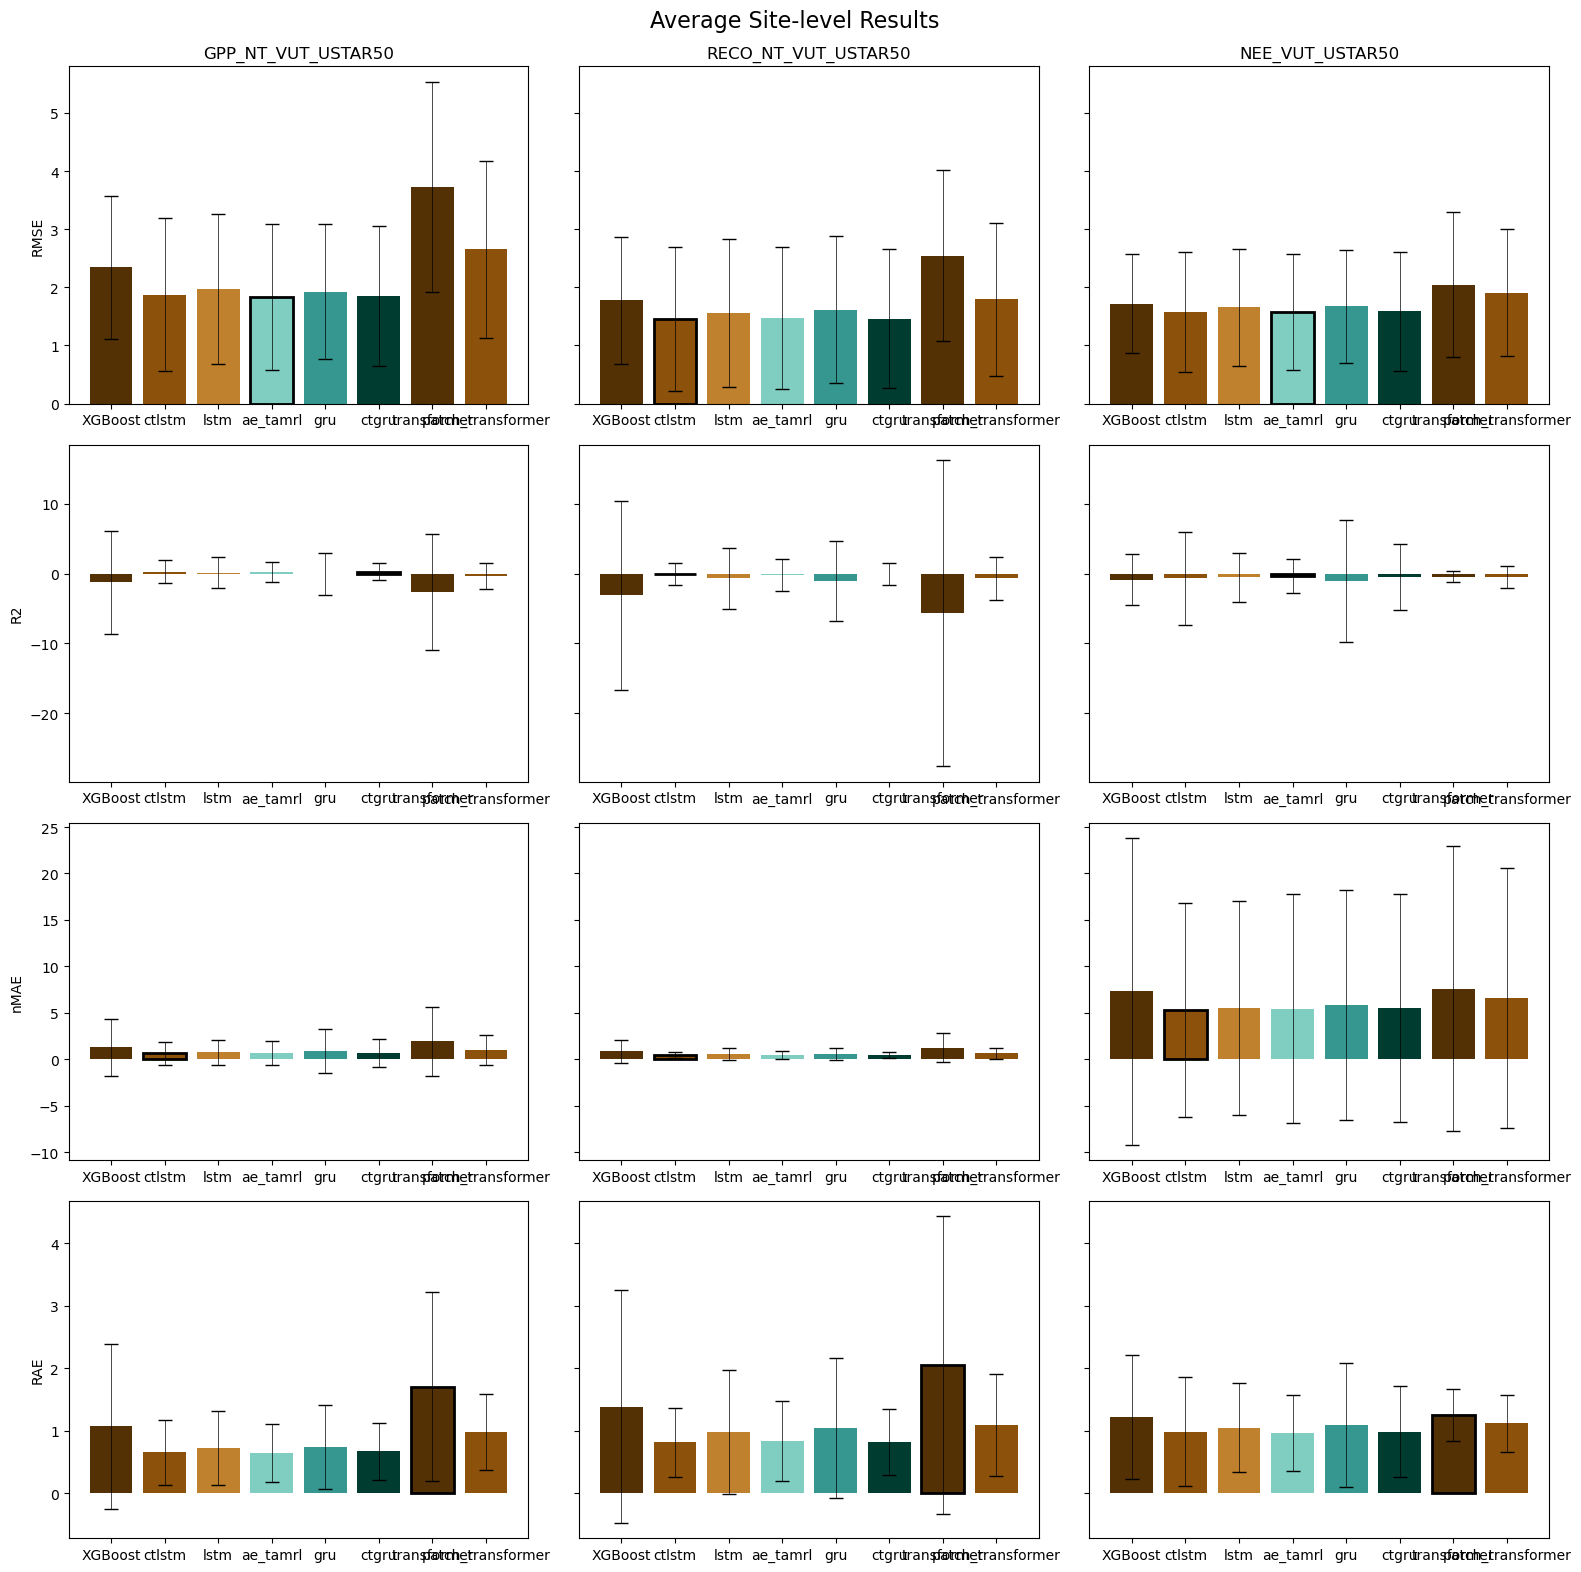

In [45]:
carbonbench.plot_bars(results, metrics, targets)

In [46]:
for target in targets:
    print("="*20, target, '='*20)
    for model in results.keys():
        res = round(results[model][target][metrics].mean().T,3)
        if len(model)<8:
            print(f"Model: {model}\t\tRMSE={res.RMSE.item()}\tR2={res.R2.item()}\tMAPE={res.nMAE.item()}")
        else:
            print(f"Model: {model}\tRMSE={res.RMSE.item()}\tR2={res.R2.item()}\tMAPE={res.nMAE.item()}")

==================== GPP_NT_VUT_USTAR50 ====================
Model: XGBoost		RMSE=2.345	R2=-1.218	MAPE=1.271
Model: ctlstm		RMSE=1.87	R2=0.275	MAPE=0.646
Model: lstm		RMSE=1.978	R2=0.13	MAPE=0.733
Model: ae_tamrl	RMSE=1.833	R2=0.301	MAPE=0.649
Model: gru		RMSE=1.927	R2=-0.015	MAPE=0.855
Model: ctgru		RMSE=1.853	R2=0.304	MAPE=0.697
Model: transformer	RMSE=3.724	R2=-2.625	MAPE=1.913
Model: patch_transformer	RMSE=2.654	R2=-0.28	MAPE=0.991
==================== RECO_NT_VUT_USTAR50 ====================
Model: XGBoost		RMSE=1.78	R2=-3.123	MAPE=0.832
Model: ctlstm		RMSE=1.456	R2=0.011	MAPE=0.455
Model: lstm		RMSE=1.558	R2=-0.666	MAPE=0.561
Model: ae_tamrl	RMSE=1.473	R2=-0.154	MAPE=0.474
Model: gru		RMSE=1.614	R2=-1.071	MAPE=0.579
Model: ctgru		RMSE=1.459	R2=-0.019	MAPE=0.457
Model: transformer	RMSE=2.546	R2=-5.656	MAPE=1.239
Model: patch_transformer	RMSE=1.792	R2=-0.671	MAPE=0.64
==================== NEE_VUT_USTAR50 ====================
Model: XGBoost		RMSE=1.718	R2=-0.838	MAPE=7.306
Model: ct

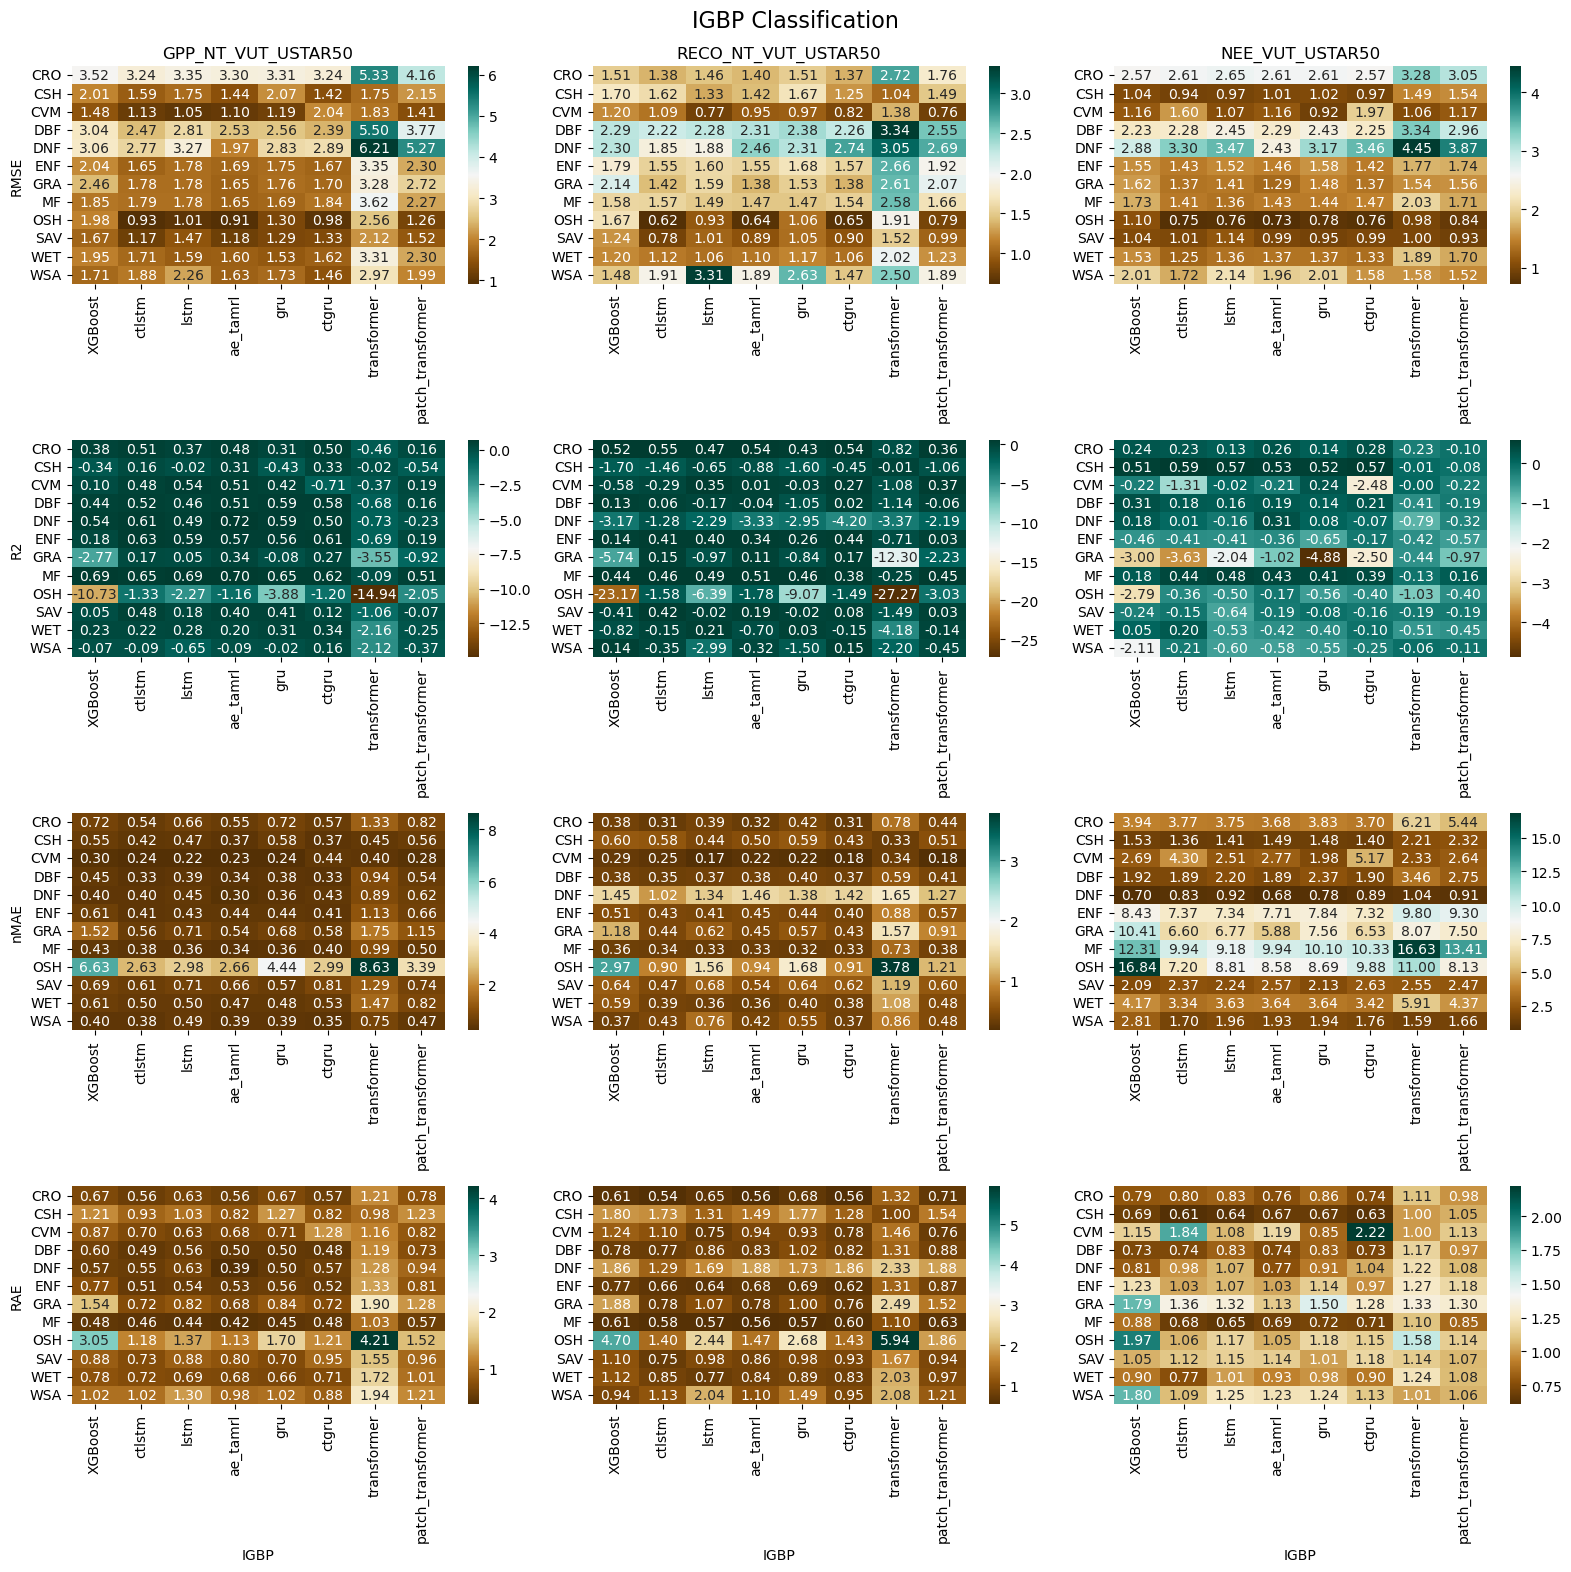

In [47]:
carbonbench.plot_heatmap(results, metrics, targets, classification='IGBP')

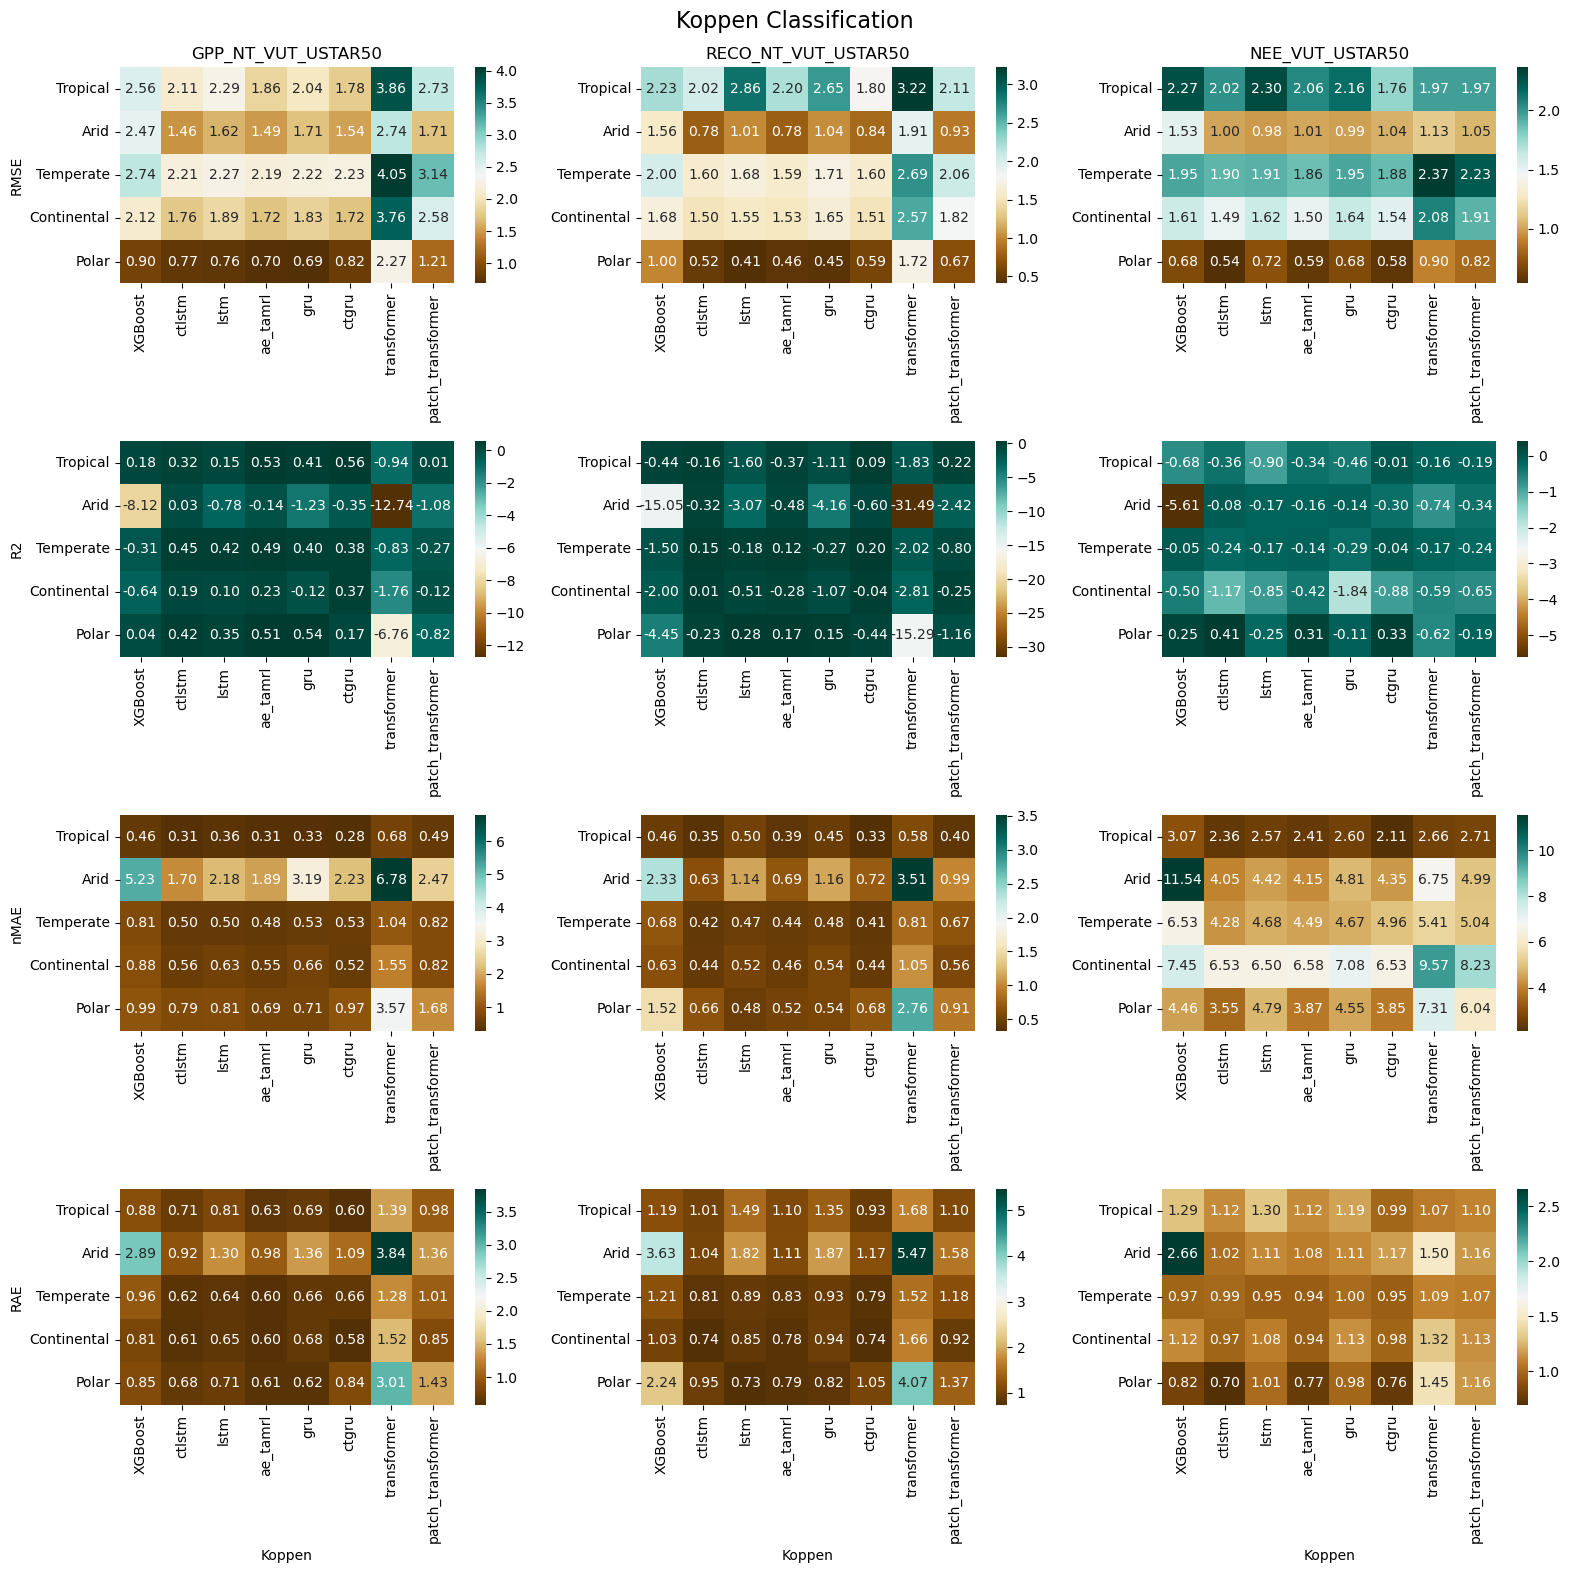

In [48]:
carbonbench.plot_heatmap(results, metrics, targets, classification='Koppen')